Time series forecasting with statsmodels

Based on

* https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
* https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [2]:
import statsmodels
statsmodels.__version__

'0.14.2'

# Obtain data

In [ ]:
# WORLDCONSUMPTION - World consumption of copper (in 1000 metric tons)
# COPPERPRICE - Constant dollar adjusted price of copper
# INCOMEINDEX - An index of real per capita income (base 1970)
# ALUMPRICE - The price of aluminum
# INVENTORYINDEX - A measure of annual manufacturer inventory trend
# TIME - A time trend

df = sm.datasets.copper.load_pandas().data
df = df.sort_values('TIME') # ensure sorting by time

df.head()

## split train and test

In [52]:
train_ratio = 0.7
n_train = int(train_ratio * df.shape[0])

df_train = df[:n_train]
df_test  = df[n_train:]

# Estimate ARIMA order

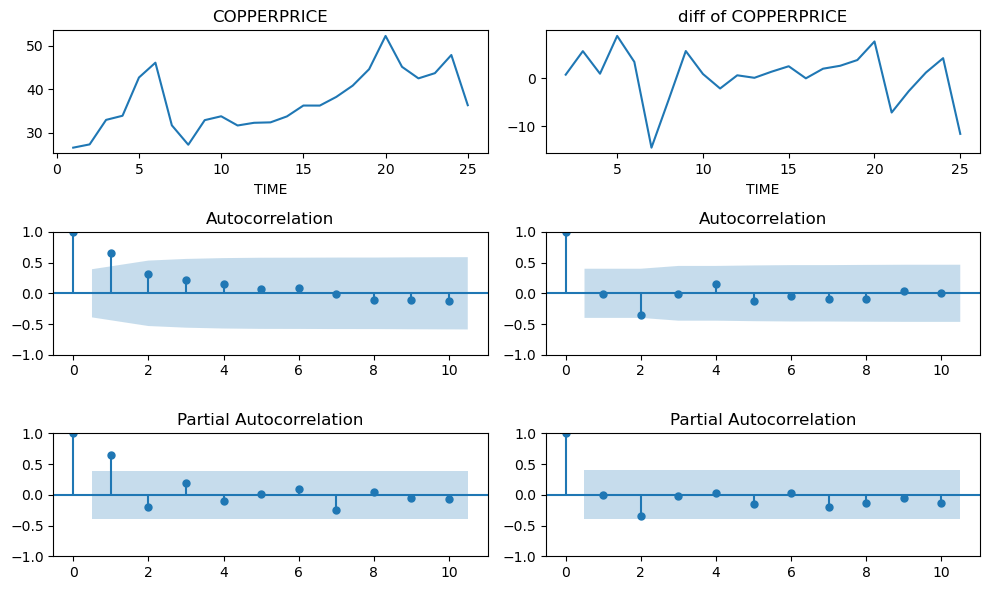

In [54]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,6))

y = df.COPPERPRICE

ax = axs[0,0]
ax.plot(df.TIME, y)
ax.set(
    title = 'COPPERPRICE',
    xlabel = 'TIME'
)

ax = axs[1,0]
sm.graphics.tsa.plot_acf(y, ax=ax, lags=10)

ax = axs[2,0]
sm.graphics.tsa.plot_pacf(y, ax=ax, lags=10)


y = np.diff(df.COPPERPRICE)

ax = axs[0,1]
ax.plot(df.TIME[1:], y)
ax.set(
    title = 'diff of COPPERPRICE',
    xlabel = 'TIME'
)

ax = axs[1,1]
sm.graphics.tsa.plot_acf(y, ax=ax, lags=10)

ax = axs[2,1]
sm.graphics.tsa.plot_pacf(y, ax=ax, lags=10)

plt.tight_layout()
plt.show()

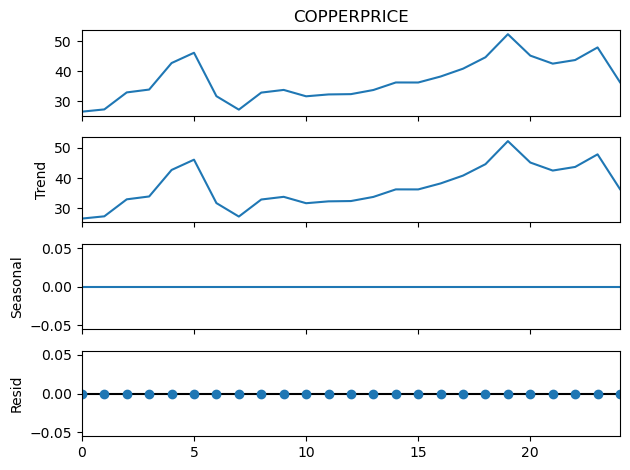

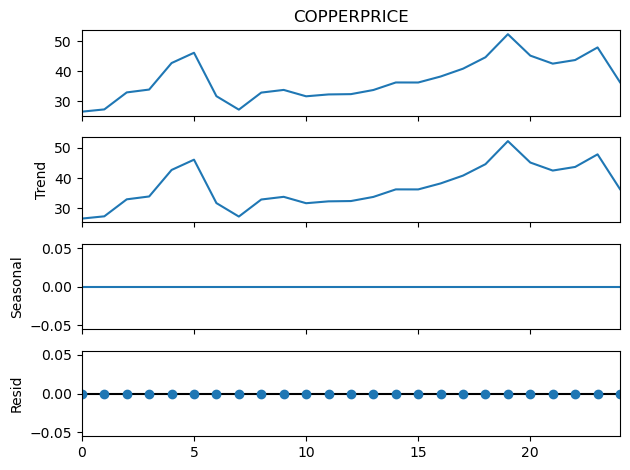

In [27]:
res = sm.tsa.seasonal_decompose(df.COPPERPRICE, period=1)
res.plot()

**Summary**: AR(1) model is appropriate

# ARIMA

## Fit ARIMA model on train data

In [194]:
model = sm.tsa.statespace.SARIMAX(df_train.COPPERPRICE, order=(1,0,0), trend='c')
results_train = model.fit()
print(results_train.summary())

                               SARIMAX Results                                
Dep. Variable:            COPPERPRICE   No. Observations:                   17
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -49.255
Date:                Fri, 03 Jan 2025   AIC                            104.510
Time:                        18:45:59   BIC                            107.009
Sample:                             0   HQIC                           104.758
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.2904      6.080      2.844      0.004       5.375      29.206
ar.L1          0.4874      0.164      2.965      0.003       0.165       0.810
sigma2        18.9298      6.807      2.781      0.0

## one-step-ahead forecast

In [140]:
# initialize model for the whole dataset
model = sm.tsa.statespace.SARIMAX(df.COPPERPRICE, order=(1,0,0), trend='c')

# use parameters obtained on train dataset
results = model.filter(results_train.params)

# one-step-ahead in-sample prediction on train parameters
predict = results.get_prediction()
predict_ci = predict.conf_int(alpha=0.05)

# one-step-ahead dynamic prediction on train parameters
# for test dates use previous forecast to get the next
predict_dyn = results.get_prediction(dynamic=n_train)
predict_dyn_ci = predict_dyn.conf_int(alpha=0.05)

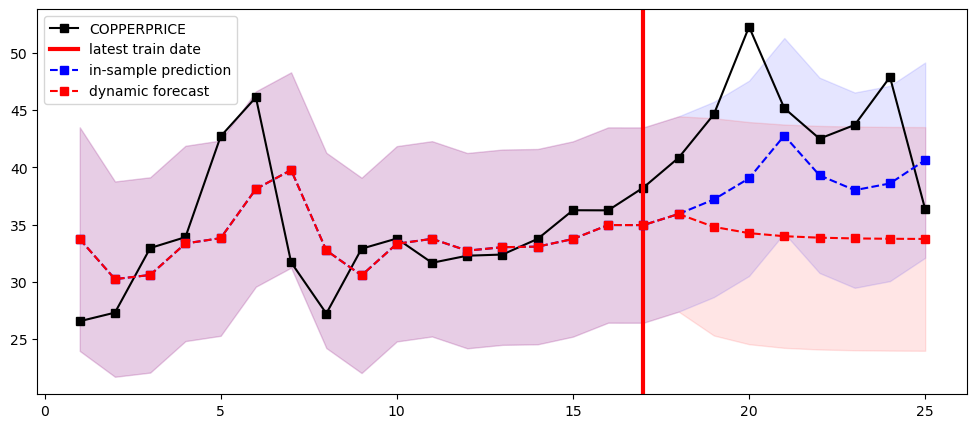

In [142]:
# Y_t - ground truth series
# Z_t - forecast

fig = plt.figure(figsize=(12,5))

# Y_t
plt.plot(df.TIME, df.COPPERPRICE, '-sk', label='COPPERPRICE')

# the latest date t^* that was used to fit parameters
plt.axvline(df_train.TIME.iloc[-1], linestyle='solid', color='r', linewidth=3, label='latest train date')

# one-step-ahead prediction Z_t | Y_{t-1}, ..., Y_1
# ! uses data from test even after t^*
plt.plot(df.TIME, predict.predicted_mean, '--sb', label='in-sample prediction')
plt.fill_between(df.TIME, predict_ci.iloc[:,0], predict_ci.iloc[:,1], color='b', alpha=0.1)

# one-step-ahead prediction Z_t | Z_{t-1}, ..., Z_{t^*+1}, Y_{t^*},..., Y_1
# ! does not use data from test after t^*, uses its own previous forecasts instead
plt.plot(df.TIME, predict_dyn.predicted_mean, '--sr', label='dynamic forecast')
plt.fill_between(df.TIME, predict_dyn_ci.iloc[:,0], predict_dyn_ci.iloc[:,1], color='r', alpha=0.1)

plt.legend(loc='upper left')
plt.show()

## out-of-sample forecast

In [196]:
# model need not be initialized again
# using train results to forecast test series
predict = results_train.get_forecast(steps=df_test.shape[0])
predict_ci = predict.conf_int(alpha=0.05)

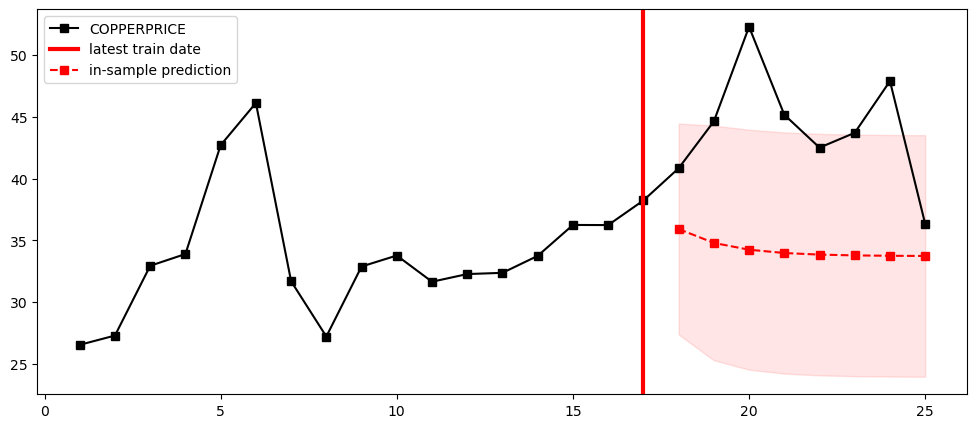

In [198]:
# Y_t - ground truth series
# Z_t - forecast

fig = plt.figure(figsize=(12,5))

# Y_t
plt.plot(df.TIME, df.COPPERPRICE, '-sk', label='COPPERPRICE')

# the latest date t^* that was used to fit parameters
plt.axvline(df_train.TIME.iloc[-1], linestyle='solid', color='r', linewidth=3, label='latest train date')

# one-step-ahead prediction Z_t | Y_{t-1}, ..., Y_1
# ! uses data from test even after t^*
plt.plot(df_test.TIME, predict.predicted_mean, '--sr', label='in-sample prediction')
plt.fill_between(df_test.TIME, predict_ci.iloc[:,0], predict_ci.iloc[:,1], color='r', alpha=0.1)

plt.legend(loc='upper left')
plt.show()

# SARIMAX

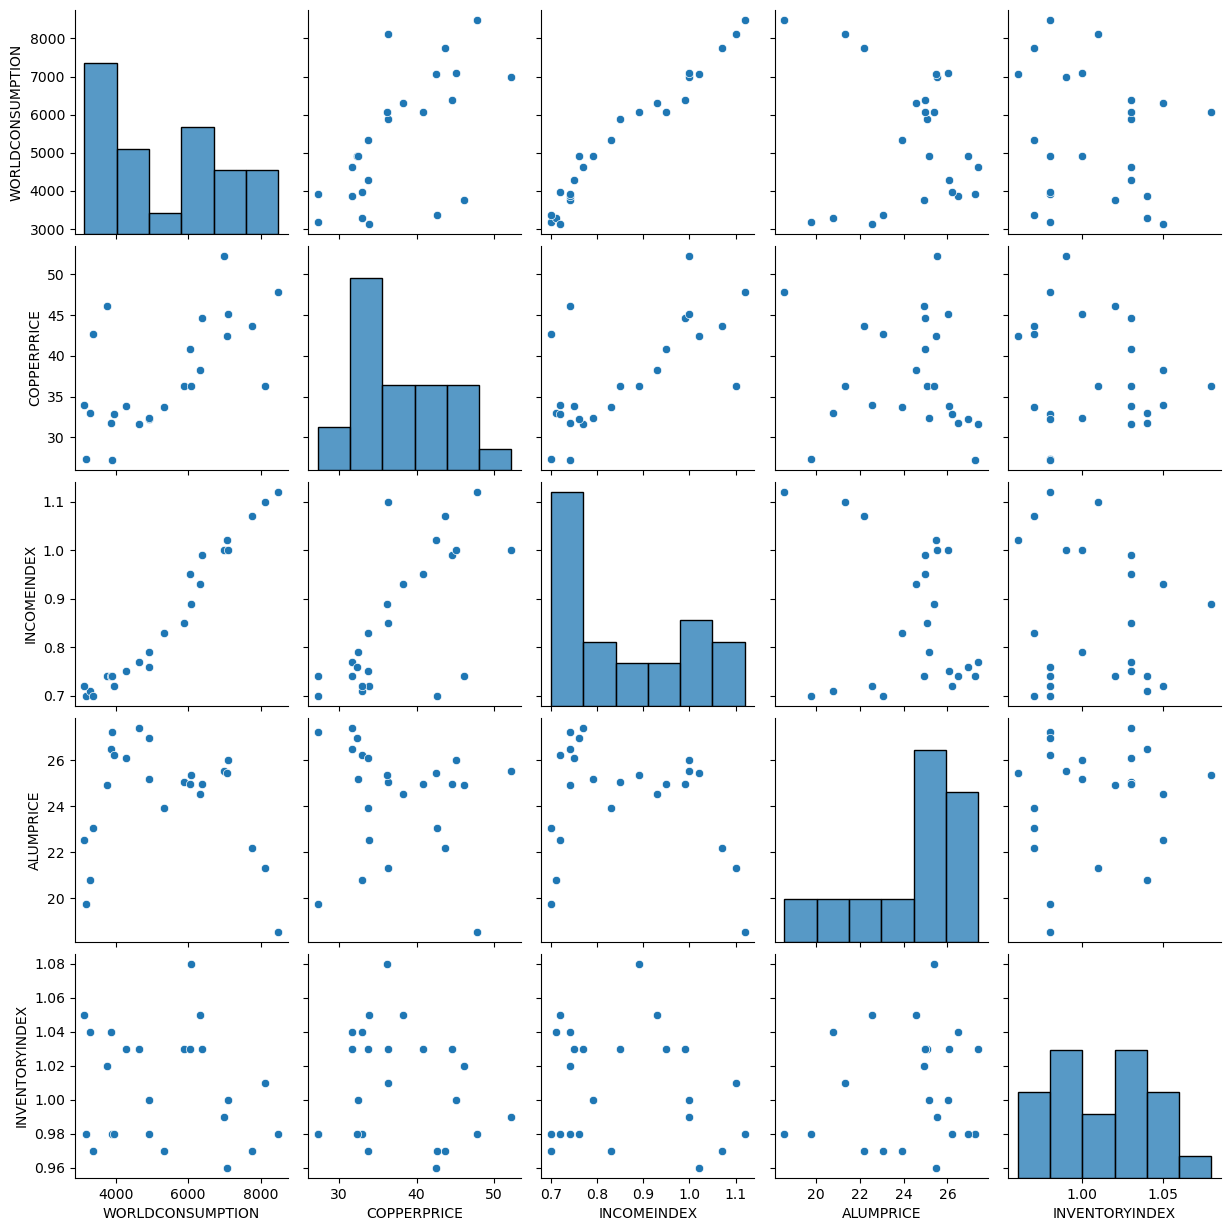

In [166]:
df_for_corr = df.drop(columns=['TIME']).copy()

df_for_corr['COPPERPRICE'] = df_for_corr['COPPERPRICE'].shift(-1)
df_for_corr = df_for_corr.dropna()

sns.pairplot(df_for_corr)

**Summary**: copper price at t is correlated with copper price at t-1 (autocorrelation) and world consumption at t-1. Hence world consumption can be used as exogenous feature in SARIMAX. 

## Fit SARIMAX model on train data

In [174]:
model = sm.tsa.statespace.SARIMAX(df_train.COPPERPRICE, exog=df_train[['WORLDCONSUMPTION']], order=(1,0,0), trend='c')
results_train = model.fit()
print(results_train.summary())

                               SARIMAX Results                                
Dep. Variable:            COPPERPRICE   No. Observations:                   17
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -50.788
Date:                Fri, 03 Jan 2025   AIC                            109.576
Time:                        18:39:09   BIC                            112.909
Sample:                             0   HQIC                           109.907
                                 - 17                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.2450      3.429     -0.071      0.943      -6.965       6.475
WORLDCONSUMPTION     0.0071      0.005      1.559      0.119      -0.002       0.016
ar.L1                0.8352 

In [207]:
np.corrcoef(df[['COPPERPRICE', 'WORLDCONSUMPTION']].T)

array([[1.        , 0.66986697],
       [0.66986697, 1.        ]])

**Summary**: results seem slightly worse after adding the feature. The feature is not significant (due to the correlation with copper price in AR).

## one-step-ahead forecast

In [180]:
# initialize model for the whole dataset
model = sm.tsa.statespace.SARIMAX(df.COPPERPRICE, exog=df[['WORLDCONSUMPTION']], order=(1,0,0), trend='c')

# use parameters obtained on train dataset
results = model.filter(results_train.params)

# one-step-ahead in-sample prediction on train parameters
predict = results.get_prediction()
predict_ci = predict.conf_int(alpha=0.05)

# one-step-ahead dynamic prediction on train parameters
# for test dates use previous forecast to get the next
predict_dyn = results.get_prediction(dynamic=n_train)
predict_dyn_ci = predict_dyn.conf_int(alpha=0.05)

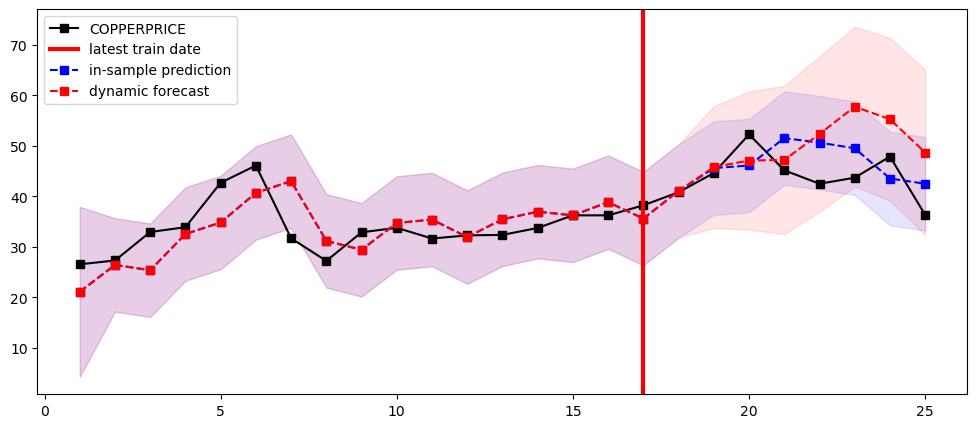

In [182]:
# Y_t - ground truth series
# Z_t - forecast

fig = plt.figure(figsize=(12,5))

# Y_t
plt.plot(df.TIME, df.COPPERPRICE, '-sk', label='COPPERPRICE')

# the latest date t^* that was used to fit parameters
plt.axvline(df_train.TIME.iloc[-1], linestyle='solid', color='r', linewidth=3, label='latest train date')

# one-step-ahead prediction Z_t | Y_{t-1}, ..., Y_1
# ! uses data from test even after t^*
plt.plot(df.TIME, predict.predicted_mean, '--sb', label='in-sample prediction')
plt.fill_between(df.TIME, predict_ci.iloc[:,0], predict_ci.iloc[:,1], color='b', alpha=0.1)

# one-step-ahead prediction Z_t | Z_{t-1}, ..., Z_{t^*+1}, Y_{t^*},..., Y_1
# ! does not use data from test after t^*, uses its own previous forecasts instead
plt.plot(df.TIME, predict_dyn.predicted_mean, '--sr', label='dynamic forecast')
plt.fill_between(df.TIME, predict_dyn_ci.iloc[:,0], predict_dyn_ci.iloc[:,1], color='r', alpha=0.1)

plt.legend(loc='upper left')
plt.show()

## out-of-sample forecast

In [188]:
# model need not be initialized again
# using train results to forecast test series
predict = results_train.get_forecast(steps=df_test.shape[0], exog=df_test[['WORLDCONSUMPTION']])
predict_ci = predict.conf_int(alpha=0.05)

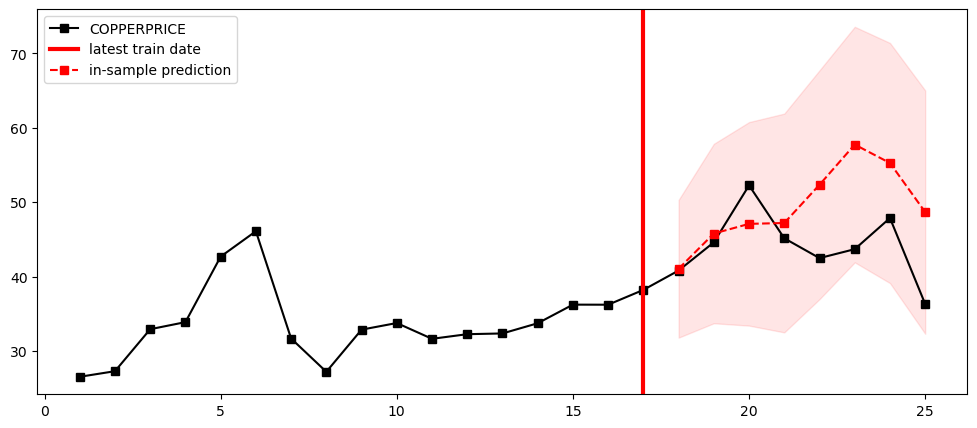

In [192]:
# Y_t - ground truth series
# Z_t - forecast

fig = plt.figure(figsize=(12,5))

# Y_t
plt.plot(df.TIME, df.COPPERPRICE, '-sk', label='COPPERPRICE')

# the latest date t^* that was used to fit parameters
plt.axvline(df_train.TIME.iloc[-1], linestyle='solid', color='r', linewidth=3, label='latest train date')

# one-step-ahead prediction Z_t | Y_{t-1}, ..., Y_1
# ! uses data from test even after t^*
plt.plot(df_test.TIME, predict.predicted_mean, '--sr', label='in-sample prediction')
plt.fill_between(df_test.TIME, predict_ci.iloc[:,0], predict_ci.iloc[:,1], color='r', alpha=0.1)

plt.legend(loc='upper left')
plt.show()

**Summary**: the forecasts seem much better since the model uses the real test values of the feature for the out-of-sample forecast.

Nevertheless, the confidence intervals are not breached for the in-sample prediction after the introduction of the feature. Hence the feature improves the one-step-ahead forecast.